In [6]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from typing import Optional, Union, Tuple, List, Dict


import pandas as pd
import numpy as np
import warnings
import inspect

https://www.aritro.in/post/exponential-smoothing-using-scikit-learn-wrapper-statsmodels/

https://www.scikit-yb.org/en/latest/_modules/yellowbrick/contrib/statsmodels/base.html#StatsModelsWrapper

In [7]:
from typing import Optional, Union, Tuple, List, Dict



class Sarimax(BaseEstimator, RegressorMixin):
    """
    A universal sklearn-style wrapper for statsmodels SARIMAX.

    Parameters
    ----------


    Attributes
    ----------

    """

    def __init__(
        self,
        order: tuple=(1, 0, 0),
        seasonal_order: tuple=(0, 0, 0, 0),
        trend: str=None,
        measurement_error: bool=False,
        time_varying_regression: bool=False,
        mle_regression: bool=True,
        simple_differencing: bool=False,
        enforce_stationarity: bool=True,
        enforce_invertibility: bool=True,
        hamilton_representation: bool=False,
        concentrate_scale: bool=False,
        trend_offset: int=1,
        use_exact_diffuse: bool=False,
        dates = None,
        freq = None,
        missing = 'none',
        validate_specification: bool=True,
        method: str='lbfgs',
        maxiter: int=50,
        start_params = None,
        disp: bool= False,
        fit_kwargs: Optional[dict]={'disp':False},
        predict_kwargs: Optional[dict]={}
    ) -> None:

        self.order                   = order
        self.seasonal_order          = seasonal_order
        self.trend                   = trend
        self.measurement_error       = measurement_error
        self.time_varying_regression = time_varying_regression
        self.mle_regression          = mle_regression
        self.simple_differencing     = simple_differencing
        self.enforce_stationarity    = enforce_stationarity
        self.enforce_invertibility   = enforce_invertibility
        self.hamilton_representation = hamilton_representation
        self.concentrate_scale       = concentrate_scale
        self.trend_offset            = trend_offset
        self.use_exact_diffuse       = use_exact_diffuse
        self.dates                   = dates
        self.freq                    = freq
        self.missing                 = missing
        self.validate_specification  = validate_specification
        self.method                  = method
        self.maxiter                 = maxiter
        self.start_params            = start_params
        self.disp                    = disp
        self.fit_kwargs              = fit_kwargs
        self.predict_kwargs          = predict_kwargs
        
        self.sarimax        = None
        self.sarimax_res    = None
        self.training_index = None
        self._dummy_create_fit_sarimax()

        # Check remove from fit_kwargs the parameters that are not in the fit method
        # of the statsmodels.SARIMAX
        fit_kwargs_keys = inspect.signature(self.sarimax.fit).parameters.keys()
        self.fit_kwargs = {k:v for k,v in self.fit_kwargs.items() if k in fit_kwargs_keys}
        # Check remove from predict_kwargs the parameters that are not in the predict method
        # of the statsmodels.SARIMAX.RESULTS
        predict_kwargs_keys = inspect.signature(self.sarimax_res.get_forecast).parameters.keys()
        self.predict_kwargs = {k:v for k,v in self.predict_kwargs.items() if k in predict_kwargs_keys}


    def _create_sarimax(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]] = None
        ) -> None:
        """
        A helper function to create a new statsmodel.SARIMAX.

        Parameters
        ----------
        y : pandas.Series
            The endogenous variable.
        exog : pandas.DataFrame
            The exogenous variables.
        
        Returns
        -------
        None

        """
        print(self.__dict__)

        self.sarimax = SARIMAX(endog=y, exog=exog, **self.__dict__)

        return
    

    def _dummy_create_fit_sarimax(self):
        """
        A helper function to create a dummy SARIMAX and fit it to an empty
        series.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        kwargs_default = {
            'method': self.method,
            'maxiter': self.maxiter,
            'start_params': self.start_params,
            'disp': self.disp,
        }
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self._create_sarimax(y=pd.Series([], dtype=float), exog=None)
            self.sarimax_res = self.sarimax.fit(**kwargs_default)
            self.training_index = pd.RangeIndex(start=0, stop=0, step=1)

        return


    def fit(
        self,
        y: pd.Series,
        exog: Optional[Union[pd.Series, pd.DataFrame]] = None
    ) -> None:
        """
        Fit the model to the data.

        Parameters
        ----------
        y : pandas Series
            Training time series.
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].

        Returns
        -------
        None

        """
        
        kwargs_default = {
            'method': self.method,
            'maxiter': self.maxiter,
            'start_params': self.start_params,
            'disp': self.disp,
        }

        # User provided fit_kwargs in the fit have preference over the default ones
        if self.fit_kwargs:
            kwargs_default.update(fit_kwargs)

        self._create_sarimax(y=y, exog=exog)
        self.sarimax_res = self.sarimax.fit(**self.fit_kwargs)
        self.training_index = y.index

        return 


    def predict(
        self,
        steps: int,
        last_window: Optional[pd.Series]=None,
        exog: Optional[Union[pd.Series, pd.DataFrame]]=None
    ):
        """
        Predict n steps ahead. It is an recursive process in which, each prediction,
        is used as a predictor for the next step.

        Parameters
        ----------
        steps : int
            Number of future steps predicted.
        last_window : pandas Series, default `None`
            Series values used to create the predictors (lags) needed in the 
            first iteration of the prediction (t + 1).
            If `last_window = None`, the values stored in `self.last_window` are
            used to calculate the initial predictors, and the predictions start
            right after training data.
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s.

        Returns
        -------
        predictions : pandas Series
            Predicted values.
        
        """

        predictions = self.sarimax_res.forecast(steps=steps, exog=exog)

        return predictions
    

    def predict_interval(self, steps, exog=None, alpha=0.05, **kwargs):
        """
        """
        predictions = self.sarimax_res.get_forecast(
                        steps           = steps,
                        exog            = exog,
                        return_conf_int = False,
                        alpha           = 0.05,
                        **kwargs
                      )
        
        predictions = pd.concat((
                        predictions.predicted_mean.rename("pred"),
                        predictions.conf_int(alpha=alpha)),
                        axis = 1
                     )
        predictions.columns = ['pred', 'lower_bound', 'upper_bound']

        return predictions
    
    def extend():
        """
        """
        pass
    

    def set_params(self, params):
        """
        
        """
        params = {k:v for k,v in params.items() if k in self.__dict__}
        for key, value in params.items():
            setattr(self, key, value)

        self._create_sarimax(
            y = pd.Series(data=self.sarimax.endog.ravel(), index=self.training_index),
            exog = self.sarimax.exog
        )
            

    def __repr__(self):
        p, d, q = self.order
        P, D, Q, m = self.seasonal_order

        return f"Sarimax({p},{d},{q})({P},{D},{Q})[{m}]"


In [14]:
args = inspect.getargvalues(Sarimax())

{'order': (1, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None, 'measurement_error': False, 'time_varying_regression': False, 'mle_regression': True, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'use_exact_diffuse': False, 'dates': None, 'freq': None, 'missing': 'none', 'validate_specification': True, 'method': 'lbfgs', 'maxiter': 50, 'start_params': None, 'disp': False, 'fit_kwargs': {'disp': False}, 'predict_kwargs': {}, 'sarimax': None, 'sarimax_res': None, 'training_index': None}


AttributeError: 'Sarimax' object has no attribute 'f_code'

In [3]:
sarimax = Sarimax(order=(5, 1, 1))

{'order': (5, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': None, 'measurement_error': False, 'time_varying_regression': False, 'mle_regression': True, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'use_exact_diffuse': False, 'dates': None, 'freq': None, 'missing': 'none', 'validate_specification': True, 'method': 'lbfgs', 'maxiter': 50, 'start_params': None, 'disp': False, 'fit_kwargs': {'disp': False}, 'predict_kwargs': {}, 'sarimax': None, 'sarimax_res': None, 'training_index': None}


LinAlgError: Schur decomposition solver error.

In [56]:
sarimax = Sarimax(order=(1, 1, 1))
sarimax.fit(y=pd.Series(np.random.normal(size=100)))
sarimax

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method', 'maxiter', 'start_params', 'disp', 'fit_kwargs', 'predict_kwargs', 'sarimax', 'sarimax_res', 'training_index']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Sarimax(1,1,1)(0,0,0)[0]

In [57]:
sarimax.predict(steps=4)

100    0.089448
101    0.094491
102    0.094429
103    0.094430
Name: predicted_mean, dtype: float64

In [58]:
sarimax.predict_interval(steps=4)

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['return_conf_int', 'alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,pred,lower_bound,upper_bound
100,0.089448,-1.962973,2.141870
101,0.094491,-1.957836,2.146818
102,0.094429,-1.957901,2.146759
103,0.094430,-1.957900,2.146760


In [54]:
sarimax.set_params({'order': (1, 0, 110)})
sarimax

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method', 'maxiter', 'start_params', 'disp', 'fit_kwargs', 'predict_kwargs', 'sarimax', 'sarimax_res', 'training_index']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Sarimax(1,0,110)(0,0,0)[0]

In [49]:
sarimax = Sarimax()
sarimax.set_params({'order': (1, 0, 99)})
sarimax

/home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method', 'maxiter', 'start_params', 'disp', 'fit_kwargs', 'predict_kwargs', 'sarimax', 'sarimax_res', 'training_index']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Sarimax(1,0,99)(0,0,0)[0]

## v2

In [1]:
import sklearn

In [19]:
def check_fitted(func):
    def wrapper(self, *args, **kwargs):

        if not self.fitted:
            raise sklearn.exceptions.NotFittedError(
                ("This Forecaster instance is not fitted yet. Call `fit` with "
                 "appropriate arguments before using predict.")
            )
        
        result = func(self, *args, **kwargs)
        
        return result
    
    return wrapper

In [78]:
from typing import Optional, Union, Tuple, List, Dict



class Sarimax2(BaseEstimator, RegressorMixin):
    """
    A universal sklearn-style wrapper for statsmodels SARIMAX.

    Parameters
    ----------


    Attributes
    ----------

    """

    def __init__(
        self,
        order: tuple=(1, 0, 0),
        seasonal_order: tuple=(0, 0, 0, 0),
        trend: str=None,
        measurement_error: bool=False,
        time_varying_regression: bool=False,
        mle_regression: bool=True,
        simple_differencing: bool=False,
        enforce_stationarity: bool=True,
        enforce_invertibility: bool=True,
        hamilton_representation: bool=False,
        concentrate_scale: bool=False,
        trend_offset: int=1,
        use_exact_diffuse: bool=False,
        dates = None,
        freq = None,
        missing = 'none',
        validate_specification: bool=True,
        method: str='lbfgs',
        maxiter: int=50,
        start_params: np.ndarray= None,
        disp: bool=False,
        sm_init_kwargs: dict={},
        sm_fit_kwargs: dict={},
        sm_predict_kwargs: dict={}
    ) -> None:

        self.order                   = order
        self.seasonal_order          = seasonal_order
        self.trend                   = trend
        self.measurement_error       = measurement_error
        self.time_varying_regression = time_varying_regression
        self.mle_regression          = mle_regression
        self.simple_differencing     = simple_differencing
        self.enforce_stationarity    = enforce_stationarity
        self.enforce_invertibility   = enforce_invertibility
        self.hamilton_representation = hamilton_representation
        self.concentrate_scale       = concentrate_scale
        self.trend_offset            = trend_offset
        self.use_exact_diffuse       = use_exact_diffuse
        self.dates                   = dates
        self.freq                    = freq
        self.missing                 = missing
        self.validate_specification  = validate_specification
        self.method                  = method
        self.maxiter                 = maxiter
        self.start_params            = start_params
        self.disp                    = disp

        # Create the dictionaries with the additional statsmodels parameters to be  
        # used during the init, fit and predict methods. Note that the statsmodels 
        # SARIMAX.fit parameters `method`, `max_iter`, `start_params` and `disp` 
        # have been moved to the initialization of this model and will have 
        # priority over those provided by the user using via `sm_fit_kwargs`.
        self.sm_init_kwargs    = sm_init_kwargs
        self.sm_fit_kwargs     = sm_fit_kwargs
        self.sm_predict_kwargs = sm_predict_kwargs

        # Params that can be set with the `set_params` method
        _, _, _, _sarimax_params = inspect.getargvalues(inspect.currentframe())
        _sarimax_params.pop("self")
        self._sarimax_params = _sarimax_params

        self._consolidate_kwargs()

        # Create Results Attributes 
        self.set_output     = None
        self.sarimax        = None
        self.fitted         = False
        self.sarimax_res    = None
        self.training_index = None


    def __repr__(self):

        p, d, q = self.order
        P, D, Q, m = self.seasonal_order
        
        return f"Sarimax({p},{d},{q})({P},{D},{Q})[{m}]"


    def _consolidate_kwargs(
        self
    ) -> None:
        """
        """
        
        # statsmodels.tsa.statespace.SARIMAX parameters
        _init_kwargs = self.sm_init_kwargs.copy()
        _init_kwargs.update({
           'order': self.order,
           'seasonal_order': self.seasonal_order,
           'trend': self.trend,
           'measurement_error': self.measurement_error,
           'time_varying_regression': self.time_varying_regression,
           'mle_regression': self.mle_regression,
           'simple_differencing': self.simple_differencing,
           'enforce_stationarity': self.enforce_stationarity,
           'enforce_invertibility': self.enforce_invertibility,
           'hamilton_representation': self.hamilton_representation,
           'concentrate_scale': self.concentrate_scale,
           'trend_offset': self.trend_offset,
           'use_exact_diffuse': self.use_exact_diffuse,
           'dates': self.dates,
           'freq': self.freq,
           'missing': self.missing,
           'validate_specification': self.validate_specification
        })
        self._init_kwargs = _init_kwargs

        # statsmodels.tsa.statespace.SARIMAX.fit parameters
        _fit_kwargs = self.sm_fit_kwargs.copy()
        _fit_kwargs.update({
           'method': self.method,
           'maxiter': self.maxiter,
           'start_params': self.start_params,
           'disp': self.disp,
        })        
        self._fit_kwargs = _fit_kwargs

        # statsmodels.tsa.statespace.SARIMAXResults.get_forecast parameters
        self._predict_kwargs = self.sm_predict_kwargs.copy()

        return
    
        
    def _create_sarimax(
        self,
        endog: Union[np.ndarray, pd.Series, pd.DataFrame],
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None
    ) -> None:
        """
        A helper function to create a new statsmodel.SARIMAX.

        Parameters
        ----------
        endog : pandas.Series
            The endogenous variable.
        exog : pandas.DataFrame
            The exogenous variables.
        
        Returns
        -------
        None

        """

        self.sarimax = SARIMAX(endog=endog, exog=exog, **self._init_kwargs)

        return


    def fit(
        self,
        y: Union[np.ndarray, pd.Series, pd.DataFrame],
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None
    ) -> None:
        """
        Fit the model to the data.

        Parameters
        ----------
        y : pandas Series
            Training time series.
        exog : pandas Series, pandas DataFrame, default `None`
            Exogenous variable/s included as predictor/s. Must have the same
            number of observations as `y` and their indexes must be aligned so
            that y[i] is regressed on exog[i].

        Returns
        -------
        None

        """

        self.set_output = 'numpy' if isinstance(y, np.ndarray) else 'pandas'
        
        self._create_sarimax(endog=y, exog=exog)
        self.sarimax_res = self.sarimax.fit(**self._fit_kwargs)
        self.fitted = True
        
        if self.set_output == 'pandas':
            self.training_index = y.index

        return
    
    @check_fitted
    def predict(
        self,
        steps: int,
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None, 
        return_conf_int: bool=False,
        alpha: float=0.05
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        """
        predictions = self.sarimax_res.get_forecast(
                          steps = steps,
                          exog  = exog,
                          **self._predict_kwargs
                      )
        
        if not return_conf_int:
            predictions = predictions.predicted_mean
            if self.set_output == 'pandas':
                predictions = predictions.rename("pred").to_frame()
        else:
            if self.set_output == 'numpy':
                predictions = np.column_stack(
                                  [predictions.predicted_mean,
                                   predictions.conf_int(alpha=alpha)]
                              )
            else:
                predictions = pd.concat((
                                  predictions.predicted_mean.rename("pred"),
                                  predictions.conf_int(alpha=alpha)),
                                  axis = 1
                              )
                predictions.columns = ['pred', 'lower_bound', 'upper_bound']

        return predictions


    @check_fitted
    def append(
        self,
        y: Union[np.ndarray, pd.Series, pd.DataFrame],
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None,
        refit: bool=False,
        copy_initialization: bool=False,
        **kwargs
    ) -> None:
        """
        """
        fit_kwargs = self._fit_kwargs if refit else None

        self.sarimax_res = self.sarimax_res.append(
                               endog               = y,
                               exog                = exog,
                               refit               = refit,
                               copy_initialization = copy_initialization,
                               fit_kwargs          = fit_kwargs,
                               **kwargs
                           )


    @check_fitted
    def apply(
        self,
        y: Union[np.ndarray, pd.Series, pd.DataFrame],
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None,
        refit: bool=False,
        copy_initialization: bool=False,
        **kwargs
    ) -> None:
        """
        """
        fit_kwargs = self._fit_kwargs if refit else None

        self.sarimax_res = self.sarimax_res.apply(
                               endog               = y,
                               exog                = exog,
                               refit               = refit,
                               copy_initialization = copy_initialization,
                               fit_kwargs          = fit_kwargs,
                               **kwargs
                           )


    @check_fitted
    def extend(
        self,
        y: Union[np.ndarray, pd.Series, pd.DataFrame],
        exog: Optional[Union[np.ndarray, pd.Series, pd.DataFrame]]=None,
        **kwargs
    ) -> None:
        """
        """

        self.sarimax_res = self.sarimax_res.extend(
                               endog               = y,
                               exog                = exog,
                               **kwargs
                           )


    def set_params(self, params):
        """
        """
        params = {k:v for k,v in params.items() if k in self._sarimax_params}
        for key, value in params.items():
            setattr(self, key, value)

        self._consolidate_kwargs()

        self.fitted = False
        self.sarimax_res = None
        self.training_index = None

        # Create the dictionaries with the additional statsmodels parameters to be  
        # used during the init, fit and predict methods. Note that the statsmodels 
        # SARIMAX.fit parameters `method`, `max_iter`, `start_params` and `disp` 
        # have been moved to the initialization of this model and will have 
        # priority over those provided by the user using via `sm_fit_kwargs`.
        
        # statsmodels.tsa.statespace.SARIMAX parameters
    

    @check_fitted
    def summary(self):
        """
        Get a summary of the ARIMA model
        """

        return self.sarimax_res.summary()


In [79]:
sarimax = Sarimax2()
sarimax

Sarimax(1,0,0)(0,0,0)[0]

In [80]:
sarimax = Sarimax2(order=(3, 1, 3))
sarimax.fit(y=np.random.normal(size=10))
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  -4.925
Date:                Fri, 28 Jul 2023   AIC                             23.850
Time:                        14:40:37   BIC                             25.230
Sample:                             0   HQIC                            20.870
                                 - 10                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0455      0.694     -1.507      0.132      -2.405       0.314
ar.L2         -0.7132      0.883     -0.808      0.419      -2.443       1.017
ar.L3         -0.6676      0.625     -1.068      0.285      -1.893       0.557
ma.L1         -0.1304     11.652     -0.011      0.991     -22.967      22.706
ma.L2         -0.0954     13.574     -0.007      0.994     -26.701      26.510
ma.L3          0.9834     12.646      0.078      0.938     -23.803      25.770
sigma2         0.0736      0.963      0.076      0.939      -1.815       1.962
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.36   Prob(JB):                         0.84
Heteroskedasticity (H):               0.40   Skew:                            -0.06
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.8e+17. Standard errors may be unstable.
"""

In [85]:
np.random.seed(123)
y_numpy = np.random.normal(size=100)
exog_numpy = np.random.normal(size=100)

print(y_numpy[:10])

sarimax = Sarimax2(order=(3, 1, 3))

sarimax.fit(y=y_numpy)

print(sarimax.sarimax_res.fittedvalues[:10])

sarimax.sarimax_res.get_prediction(0, 10).predicted_mean

[-1.0856306   0.99734545  0.2829785  -1.50629471 -0.57860025  1.65143654
 -2.42667924 -0.42891263  1.26593626 -0.8667404 ]
[ 0.         -1.08562935  0.04582749 -0.14900331 -0.14813861 -0.40764005
 -0.0495173  -0.47471492 -0.15535394 -0.40907418]


array([ 0.        , -1.08562935,  0.04582749, -0.14900331, -0.14813861,
       -0.40764005, -0.0495173 , -0.47471492, -0.15535394, -0.40907418,
       -0.21411125])

In [67]:
#Check fit predict work

# If both are pandas, both needs to have an aligned index

np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')

y_numpy = np.random.normal(size=100)
y_serie = pd.Series(np.random.normal(size=100), name='y')
y_df = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['serie_1'])
y_df_index = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['serie_1'])
y_df_index.index = pd.period_range(start='2000', periods=100, freq='A')

exog_numpy = np.random.normal(size=100)
exog_serie = pd.Series(np.random.normal(size=100), name='exog')
exog_df = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['exog_1'])
exog_df_index = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['exog_1'])
exog_df_index.index = pd.period_range(start='2000', periods=100, freq='A')

data = [('1', y_numpy, exog_numpy),
        ('2', y_numpy, exog_serie),
        ('3', y_numpy, exog_df),
        ('4', y_numpy, exog_df_index),
        ('5', y_serie, exog_numpy),
        ('6', y_serie, exog_serie),
        ('7', y_serie, exog_df),
        # ('8', y_serie, exog_df_index), not works!!!
        ('9', y_df, exog_numpy),
        ('10', y_df, exog_serie),
        ('11', y_df, exog_df),
        # ('12', y_df, exog_df_index), not works!!!
        ('13', y_df_index, exog_numpy),
        # ('14', y_df_index, exog_serie), not works!!!
        # ('15', y_df_index, exog_df), not works!!!
        ('16', y_df_index, exog_df_index) # not error in predict (unaligned index)
        ]

for i, dat in enumerate(data):

    y = dat[1]
    exog = dat[2]

    sarimax = Sarimax2(order=(3, 1, 3))

    print(dat[0])
    print(type(y), type(exog))

    sarimax.fit(y=y, exog=exog)

    predictions = sarimax.predict(5, exog=exog[:5], return_conf_int=True)

    print(type(predictions))
    print("---")

1
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
---
2
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
---
3
<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
---
4
<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
---
5
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
---
6
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
---
7
<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
---
9
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
---
10
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
---
11
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class

In [52]:
np.random.seed(123)
endog = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['serie_1'])
endog.index = pd.period_range(start='2000', periods=100, freq='A')
#endog = pd.Series(np.random.normal(size=100))
#endog = np.random.normal(size=100)

exog = np.random.normal(size=100)
#exog = pd.Series(np.random.normal(size=100))

sarimax = Sarimax2(order=(3, 1, 3))
sarimax.fit(y=endog, exog=exog)

predictions = sarimax.predict(5, exog=exog[:5], return_conf_int=True)
print(type(predictions))
predictions

<class 'pandas.core.frame.DataFrame'>


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,pred,lower_bound,upper_bound
2100,-0.098987,-2.282301,2.084327
2101,-0.050396,-2.235456,2.134664
2102,-0.080658,-2.265786,2.104471
2103,0.152617,-2.083585,2.388818
2104,-0.028069,-2.265317,2.209178


In [53]:
new_index = pd.period_range(start='2100', periods=100, freq='A')
new_observations = pd.Series(np.random.normal(size=100))
new_observations.index = new_index

new_exog = np.random.normal(size=100)

print(sarimax.sarimax_res.fittedvalues.tail(5))
print("")

sarimax.append(
    y     = new_observations, 
    exog  = new_exog,
    refit = False
)

print(sarimax.sarimax_res.fittedvalues.tail(5))

2095    0.204505
2096    0.040547
2097    0.031692
2098    0.205036
2099   -0.208554
Freq: A-DEC, dtype: float64

2195   -0.194349
2196   -0.002907
2197   -0.385071
2198    0.192968
2199    0.149047
Freq: A-DEC, dtype: float64


In [59]:
exog[:5]

0    0.703310
1   -0.598105
2    2.200702
3    0.688297
4   -0.006307
dtype: float64

In [38]:
arr1 = np.array([0.76578498, 0.79847458, 0.73380039, 0.86588736, 0.96231786])
arr2 = np.array([[-1.20204223,  2.7336122 ],
 [-1.20640858 , 2.80335774],
 [-1.28768676 , 2.75528753],
 [-1.16192687,  2.89370158],
 [-1.18203997,  3.10667568]])

In [40]:
np.column_stack([arr1,arr2])

array([[ 0.76578498, -1.20204223,  2.7336122 ],
       [ 0.79847458, -1.20640858,  2.80335774],
       [ 0.73380039, -1.28768676,  2.75528753],
       [ 0.86588736, -1.16192687,  2.89370158],
       [ 0.96231786, -1.18203997,  3.10667568]])

In [27]:
sarimax.predict_kwargs

{}

## Statsmodels

In [13]:
np.random.seed(123)
endog = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['serie_1'])
endog = pd.DataFrame(pd.Series(np.random.normal(size=100)), columns=['serie_1'])

sarimax = SARIMAX(order=(3, 3, 3), endog=endog)
sarimax_res = sarimax.fit()

type(sarimax_res.get_forecast(5).predicted_mean)

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


pandas.core.series.Series

In [12]:
endog

,serie_1
0,-1.085631
1,0.997345
2,0.282978
3,-1.506295
4,-0.578600
...,...
95,1.031114
96,-1.084568
97,-1.363472
98,0.379401


In [87]:
sarimax.missing

AttributeError: 'SARIMAX' object has no attribute 'missing'

In [78]:
np.random.seed(123)
sarimax = Sarimax2(order=(3, 3, 3))
sarimax.fit(y=np.random.normal(size=100))

sarimax.predict(5)

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


array([-0.66263334, -0.17596637, -0.43844843, -0.52160303, -0.39956411])

In [70]:
sarimax = Sarimax(order=(1,1,1), maxiter=133)
sarimax.fit(y=np.random.normal(size=100))

In [71]:
sarimax.params()

array([-0.1931783 , -0.99980359,  0.82767352])

In [72]:
sarimax._sarimax_params

{'order': (1, 1, 1),
 'seasonal_order': (0, 0, 0, 0),
 'trend': None,
 'measurement_error': False,
 'time_varying_regression': False,
 'mle_regression': True,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'use_exact_diffuse': False,
 'dates': None,
 'freq': None,
 'missing': 'none',
 'validate_specification': True,
 'method': 'lbfgs',
 'maxiter': 133,
 'start_params': None,
 'disp': False,
 'sm_init_kwargs': {},
 'sm_fit_kwargs': {},
 'sm_predict_kwargs': {}}

In [73]:
sarimax.set_params(order=(2,2,2))
sarimax.order

{'order': (2, 2, 2)}


(2, 2, 2)

## Test Forecaster Sarimax

In [3]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [68]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterSarimax_2 import ForecasterSarimax
from skforecast.ForecasterSarimax_2 import Sarimax
from pmdarima import ARIMA

Train dates : 1991-07-01 00:00:00 --- 2005-06-01 00:00:00  (n=168)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


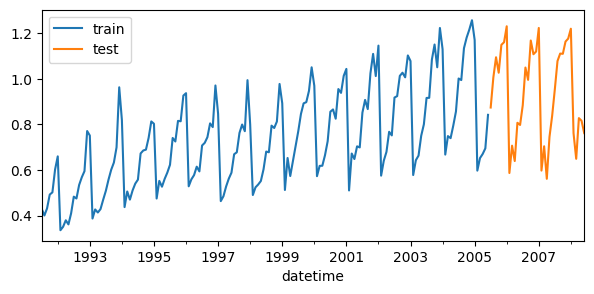

In [82]:
# Download data
# ======================================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ======================================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Train-test dates
# ======================================================================================
end_train = '2005-06-01 23:59:00'
print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  (n={len(data.loc[end_train:])})")
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [75]:
# Create ForecasterSarimax
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=ARIMA(maxiter=1000, trend=None, method='nm', ftol=1e-19,order=(1,1,1))
             )
forecaster.fit(y=data_train)
predictions = forecaster.predict(steps=5)
predictions

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2005-07-01    0.894239
2005-08-01    0.926416
2005-09-01    0.946765
2005-10-01    0.960049
2005-11-01    0.969112
Freq: MS, Name: pred, dtype: float64

In [83]:
# Create ForecasterSarimax
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(maxiter=200, order=(12,1,1))
             )
forecaster.fit(y=data_train)

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [86]:
%%timeit -n 10

regressor=ARIMA(maxiter=1000, trend=None, method='nm', ftol=1e-19,order=(1,1,1))
regressor.fit(y=data_train)
predictions = regressor.predict(n_periods=5)

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarn

471 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['ftol']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [87]:
%%timeit -n 10

regressor=Sarimax(maxiter=1000, trend=None, method='nm', 
                  sm_fit_kwargs={'ftol':1e-19}, order=(1,1,1))
regressor.fit(y=data_train)
predictions = regressor.predict(steps=5)

278 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

regressor=SARIMAX(endog=data_train, order=(1,1,1))
arima_res = regressor.fit(maxiter=1000, trend=None, method='nm', ftol=1e-19)
predictions = arima_res.get_forecast(steps=5)
predictions.predicted_mean

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: trend. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.577057
         Iterations: 266
         Function evaluations: 516


2005-07-01    0.860220
2005-08-01    0.871467
2005-09-01    0.878513
2005-10-01    0.882926
2005-11-01    0.885690
Freq: MS, Name: predicted_mean, dtype: float64

In [84]:
# Predict
# ======================================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.954925
2005-08-01    0.957182
2005-09-01    1.107026
Freq: MS, Name: pred, dtype: float64

In [40]:
forecaster.get_feature_importances()

,feature,importance
0,ar.L1,-0.037589
1,ar.L2,-0.070507
2,ar.L3,-0.040790
3,ar.L4,-0.092181
4,ar.L5,-0.054623
5,ar.L6,-0.046340
6,ar.L7,-0.091918
7,ar.L8,-0.038640
8,ar.L9,-0.065848
9,ar.L10,-0.066498


### Backtesting

In [42]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200)
             )

metric, predictions = backtesting_sarimax(
                          forecaster         = forecaster,
                          y                  = data,
                          initial_train_size = len(data_train),
                          fixed_train_size   = False,
                          steps              = 12,
                          metric             = 'mean_absolute_error',
                          refit              = True,
                          n_jobs             = -1,
                          verbose            = True,
                          show_progress      = True
                      )

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Information of backtesting process
----------------------------------
Number of observations used for initial training: 168
Number of observations used for backtesting: 36
    Number of folds: 3
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1991-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=168)
    Validation: 2005-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=12)
Fold: 1
    Training:   1991-07-01 00:00:00 -- 2006-06-01 00:00:00  (n=180)
    Validation: 2006-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=12)
Fold: 2
    Training:   1991-07-01 00:00:00 -- 2007-06-01 00:00:00  (n=192)
    Validation: 2007-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=12)



  0%|          | 0/3 [00:00<?, ?it/s]

## Grid

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


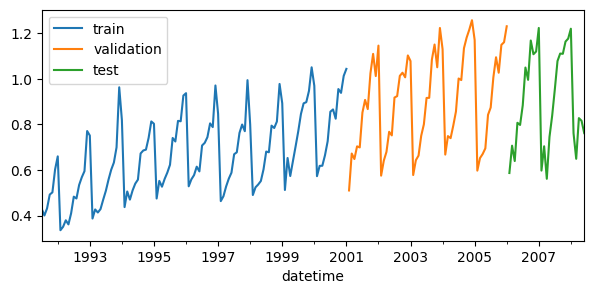

In [43]:
# Train-validation-test data
# ======================================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

In [60]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200)
             )

forecaster.regressor._sarimax_params

{'order': (12, 1, 1),
 'seasonal_order': (0, 0, 0, 0),
 'trend': None,
 'measurement_error': False,
 'time_varying_regression': False,
 'mle_regression': True,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'use_exact_diffuse': False,
 'dates': None,
 'freq': None,
 'missing': 'none',
 'validate_specification': True,
 'method': 'lbfgs',
 'maxiter': 200,
 'start_params': None,
 'disp': False,
 'sm_init_kwargs': {},
 'sm_fit_kwargs': {},
 'sm_predict_kwargs': {}}

In [61]:
forecaster.set_params({'order': (1,1,1)})
forecaster.regressor.order

{'order': (1, 1, 1)}


(1, 1, 1)

In [62]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(12, 1, 1), seasonal_order=(0, 0, 0, 0), maxiter=200)
             )

param_grid = {
    'order': [(12, 0, 0), (12, 1, 0), (12, 1, 1), (14, 1, 4)],
    'seasonal_order': [(0, 0, 0, 0)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_val],
                   param_grid         = param_grid,
                   steps              = 12,
                   refit              = True,
                   metric             = 'mean_absolute_error',
                   initial_train_size = len(data_train),
                   fixed_train_size   = False,
                   return_best        = True,
                   n_jobs             = -1,
                   verbose            = False,
                   show_progress      = True
               )

results_grid.head(5)

Number of models compared: 12.


params grid:   0%|          | 0/12 [00:00<?, ?it/s]

{'order': (12, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (12, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (12, 0, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': None}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (12, 1, 0), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': None}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


{'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': None}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': 'n'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (14, 1, 4), 'seasonal_order': (0, 0, 0, 0), 'trend': 'c'}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': None}


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (12, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'trend': None}
  Backtesting metric: 0.06799312252877558



,params,mean_absolute_error,order,seasonal_order,trend
6,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.067993,"(12, 1, 1)","(0, 0, 0, 0)",None
7,"{'order': (12, 1, 1), 'seasonal_order': (0, 0,...",0.067993,"(12, 1, 1)","(0, 0, 0, 0)",n
9,"{'order': (14, 1, 4), 'seasonal_order': (0, 0,...",0.072158,"(14, 1, 4)","(0, 0, 0, 0)",None
10,"{'order': (14, 1, 4), 'seasonal_order': (0, 0,...",0.072158,"(14, 1, 4)","(0, 0, 0, 0)",n
2,"{'order': (12, 0, 0), 'seasonal_order': (0, 0,...",0.076132,"(12, 0, 0)","(0, 0, 0, 0)",c


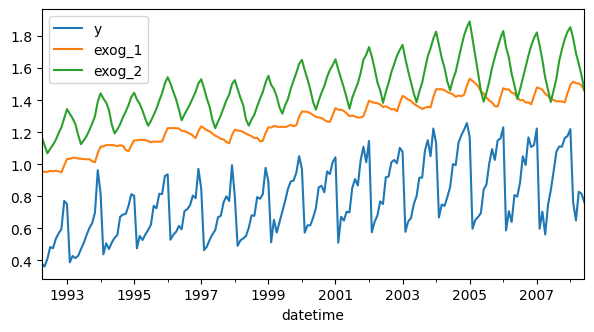

In [18]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o_exog.csv'
)
data = pd.read_csv(
            url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2']
       )

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data.plot(ax=ax);

### Tests

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [8]:
import re
import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterSarimax_2 import ForecasterSarimax
from skforecast.utils import expand_index
from pmdarima.arima import ARIMA
from skforecast.ForecasterSarimax_2 import Sarimax
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAXResultsWrapper

# Fixtures
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import y
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import y_lw
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_lw
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_predict
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_lw_predict
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import y_datetime
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import y_lw_datetime
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_datetime
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_lw_datetime
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_predict_datetime
from skforecast.ForecasterSarimax_2.tests.fixtures_ForecasterSarimax import exog_lw_predict_datetime

y_numpy = y.to_numpy()
exog_numpy = exog.to_numpy()
exog_predict_numpy = exog_predict.to_numpy()

y_lw_numpy = y_lw.to_numpy()
exog_lw_numpy = exog_lw.to_numpy()
exog_lw_predict_numpy = exog_lw_predict.to_numpy()

In [4]:
sarimax = Sarimax(order=(1,1,1), maxiter=1000, method='cg', disp=False)
sarimax.fit(y=y_numpy, exog=exog_numpy)

predictions = sarimax.predict(steps=10, exog=exog_predict_numpy,
                             return_conf_int=True, alpha=0.05)
predictions

array([[ 0.54251563, -1.19541248,  2.28044374],
       [ 0.57444558, -1.81113178,  2.96002293],
       [ 0.60419802, -2.26035953,  3.46875557],
       [ 0.63585684, -2.62746432,  3.899178  ],
       [ 0.67238625, -2.94147506,  4.28624756],
       [ 0.70992311, -3.22142148,  4.64126771],
       [ 0.76089838, -3.46329933,  4.98509609],
       [ 0.7855481 , -3.7121082 ,  5.28320441],
       [ 0.73117064, -4.02408271,  5.48642398],
       [ 0.669226  , -4.3302976 ,  5.66874961]])

In [32]:
sarimax = SARIMAX(order=(1, 1, 1), endog=y_numpy, exog=exog_numpy)               
sarimax_res = sarimax.fit(maxiter=1000, method='cg', disp=False)
preds_statsmodels = sarimax_res.get_forecast(
                        steps = 10, 
                        exog  = exog_lw_predict
                    ).predicted_mean
preds_statsmodels

array([0.70870546, 0.74591798, 0.80087547, 0.84137668, 0.87155524,
       0.90588793, 0.84485364, 0.79000535, 0.73376251, 0.67388625])

In [31]:
%%timeit -r 10

updated_res = sarimax_res.extend(
    endog      = y_lw_numpy, 
    exog       = exog_lw_numpy
)
preds_statsmodels = updated_res.get_forecast(
                        steps = 10, 
                        exog  = exog_lw_predict_numpy
                    ).predicted_mean
preds_statsmodels

3.76 ms ± 228 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [33]:
%%timeit -r 10

updated_res = sarimax_res.append(
    endog      = y_lw_numpy, 
    exog       = exog_lw_numpy
)
preds_statsmodels = updated_res.get_forecast(
                        steps = 10, 
                        exog  = exog_lw_predict_numpy
                    ).predicted_mean
preds_statsmodels

4.34 ms ± 284 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [26]:
sarimax = SARIMAX(order=(1, 0, 1), endog=y_numpy, exog=exog_numpy)               
sarimax_res = sarimax.fit(maxiter=1000, method='cg', disp=False)

updated_res = sarimax_res.apply(
    endog      = y_lw_numpy, 
    exog       = exog_lw_numpy, 
    refit      = True,
    fit_kwargs = {'method': 'cg', 'maxiter': 1000, 'start_params': None, 'disp': True}
)
preds_statsmodels = updated_res.get_forecast(
                        steps = 10, 
                        exog  = exog_lw_predict_numpy
                    ).predicted_mean
preds_statsmodels

Optimization terminated successfully.
         Current function value: -0.821442
         Iterations: 104
         Function evaluations: 251
         Gradient evaluations: 251


array([0.76718596, 0.75795261, 0.79506182, 0.81508184, 0.83164173,
       0.84979957, 0.81751954, 0.78846941, 0.75867965, 0.72695935])

In [20]:
sarimax = Sarimax(order=(1, 0, 1), maxiter=1000, method='cg', disp=False)
sarimax.fit(y=y_numpy, exog=exog_numpy)
sarimax.append(
    y     = y_lw_numpy, 
    exog  = exog_lw_numpy,
    refit = True
)
preds_skforecast = sarimax.predict(steps=10, exog=exog_lw_predict_numpy)
preds_skforecast

array([0.73036069, 0.72898841, 0.76386263, 0.78298827, 0.7990083 ,
       0.81640187, 0.78540917, 0.75749361, 0.72887628, 0.69840139])

In [34]:
sarimax = Sarimax(order=(1, 0, 1), maxiter=1000, method='cg', disp=False)
sarimax.fit(y=y_lw_numpy, exog=exog_lw_numpy)
preds_skforecast = sarimax.predict(steps=10, exog=exog_lw_predict_numpy)
preds_skforecast

array([0.76718596, 0.75795261, 0.79506182, 0.81508184, 0.83164173,
       0.84979957, 0.81751954, 0.78846941, 0.75867965, 0.72695935])

In [47]:
sarimax = Sarimax(order=(1, 0, 1))
sarimax.fit(y=y_numpy, exog=exog_numpy)
sum1 = sarimax.summary()

In [55]:
sarimax = Sarimax(order=(1, 0, 1))
sarimax.fit(y=y, exog=exog)
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  42.591
Date:                Tue, 01 Aug 2023   AIC                            -77.181
Time:                        21:16:43   BIC                            -69.533
Sample:                             0   HQIC                           -74.269
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog           0.4681      0.027     17.453      0.000       0.416       0.521
ar.L1          0.2492      0.252      0.989      0.323      -0.245       0.743
ma.L1          0.4503      0.211      2.130      0.033       0.036       0.865
sigma2         0.0106      0.002      5.168      0.000       0.007       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.87
Prob(Q):                              0.97   Prob(JB):                         0.03
Heteroskedasticity (H):               1.59   Skew:                            -0.68
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
sarimax.summary().as_text()[:316]

'                               SARIMAX Results                                \n==============================================================================\nDep. Variable:                      y   No. Observations:                   50\nModel:               SARIMAX(1, 0, 1)   Log Likelihood                  42.591\n'

In [54]:
sarimax.summary().as_html()

'<table class="simpletable">\n<caption>SARIMAX Results</caption>\n<tr>\n  <th>Dep. Variable:</th>           <td>y</td>        <th>  No. Observations:  </th>   <td>50</td>   \n</tr>\n<tr>\n  <th>Model:</th>           <td>SARIMAX(1, 0, 1)</td> <th>  Log Likelihood     </th> <td>42.591</td> \n</tr>\n<tr>\n  <th>Date:</th>            <td>Tue, 01 Aug 2023</td> <th>  AIC                </th> <td>-77.181</td>\n</tr>\n<tr>\n  <th>Time:</th>                <td>21:13:26</td>     <th>  BIC                </th> <td>-69.533</td>\n</tr>\n<tr>\n  <th>Sample:</th>                  <td>0</td>        <th>  HQIC               </th> <td>-74.269</td>\n</tr>\n<tr>\n  <th></th>                       <td> - 50</td>      <th>                     </th>    <td> </td>   \n</tr>\n<tr>\n  <th>Covariance Type:</th>        <td>opg</td>       <th>                     </th>    <td> </td>   \n</tr>\n</table>\n<table class="simpletable">\n<tr>\n     <td></td>       <th>coef</th>     <th>std err</th>      <th>z</th>      